This notebook contains:

-   Speeding violations citation rates (based on single speeding violation)

-   speeding-only logistic regression (include single speeding violation, multiple speeding violations)

-   school zone logistic regression (all year combined, the only violation is 'speeding-school zone')

-   Race distribution **of citation** in speeding over limit (% of drivers getting citation)

-   Race distribution in speeding over limit (# driver has a single violation and it is 'speeding over limit'/ # driver has single speeding violation)

- Race distribution of **search_conducted** in speeding only (# drivers searched/ # drivers have only speeding violation)

- Race distribution of **search_conducted** in low-citation-rate speeding only (# drivers searched/ # drivers have only speeding violation)

- Ratio of contraband found divided by vehicle searched for individual races




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
import os 
drive.mount('/gdrive/')

Mounted at /gdrive/


### Check Data

In [15]:
for year in list(range(2006, 2018)):
  data = pd.read_parquet('/gdrive/MyDrive/traffic_stop/year_data/traffic_' +str(year) + '.parquet', engine = 'pyarrow')
  print(year, ': ',sum(data['citation_issued'].isnull()))

2006 :  0
2007 :  0
2008 :  0
2009 :  0
2010 :  0
2011 :  0
2012 :  0
2013 :  0
2014 :  0
2015 :  0
2016 :  0
2017 :  0


In [22]:
data = pd.read_parquet('/gdrive/MyDrive/traffic_stop/year_data/traffic_2010.parquet', engine = 'pyarrow')
data.loc[data.duplicated(keep = False),:]

,raw_row_number,date,time,location,lat,lng,county_name,district,precinct,region,subject_race,subject_sex,officer_id_hash,type,violation,citation_issued,warning_issued,outcome,contraband_found,contraband_drugs,contraband_weapons,search_conducted,search_vehicle,search_basis,vehicle_color,vehicle_make,vehicle_model,vehicle_type,vehicle_year,raw_HA_RACE_SEX,raw_HA_SEARCH_PC_boolean,raw_HA_SEARCH_CONCENT_boolean,raw_HA_INCIDTO_ARREST_boolean,raw_HA_VEHICLE_INVENT_boolean,year


In [5]:
data = pd.read_parquet('/gdrive/MyDrive/traffic_stop/year_data_speeding_only/traffic_2008.parquet', engine = 'pyarrow')

In [18]:
data = data[['date','time','county_name','subject_race','subject_sex','violation','citation_issued','contraband_found']]

In [8]:
cols = list(data.columns).remove('all_violation')

In [17]:
data.head()

,date,time,county_name,subject_race,subject_sex,violation,citation_issued,contraband_found,contraband_drugs,contraband_weapons,search_conducted,search_vehicle,lat,lng,all_violation,speeding_only,county_type,sunset,sunrise,dawn,dusk,stop_time,light_cat,holiday
0,2008-01-01,00:24:00,Jasper County,white,male,speeding over limit,0,0,0,0,0,0,31.143032,-93.985649,[speeding over limit],speeding-1,Non core,2008-01-01 17:24:11,2008-01-01 07:14:40,2008-01-01 06:47:30,2008-01-01 17:51:20,2008-01-01 00:24:00,dark,1
1,2008-01-01,00:36:00,Smith County,black,female,speeding over limit,0,0,0,0,0,0,32.247066,-95.395080,[speeding over limit],speeding-1,Metropolitan,2008-01-01 17:27:12,2008-01-01 07:22:55,2008-01-01 06:55:23,2008-01-01 17:54:44,2008-01-01 00:36:00,dark,1
2,2008-01-01,00:42:00,Smith County,white,male,speeding over limit,0,0,0,0,0,0,32.247566,-95.388420,[speeding over limit],speeding-1,Metropolitan,2008-01-01 17:27:10,2008-01-01 07:22:54,2008-01-01 06:55:22,2008-01-01 17:54:42,2008-01-01 00:42:00,dark,1
3,2008-01-01,00:48:00,Walker County,white,male,speeding over limit,0,0,0,0,0,0,30.847082,-95.407997,[speeding over limit],speeding-1,Micropolitan,2008-01-01 17:30:34,2008-01-01 07:19:39,2008-01-01 06:52:36,2008-01-01 17:57:37,2008-01-01 00:48:00,dark,1
4,2008-01-01,00:59:00,Navarro County,asian/pacific islander,male,speeding over limit,0,0,0,0,0,0,31.977449,-96.422935,[speeding over limit],speeding-1,Micropolitan,2008-01-01 17:31:57,2008-01-01 07:26:23,2008-01-01 06:58:57,2008-01-01 17:59:24,2008-01-01 00:59:00,dark,1


In [18]:
data.loc[data['holiday'] == False,:].iloc[4000:4005]

,date,time,county_name,subject_race,subject_sex,violation,citation_issued,contraband_found,contraband_drugs,contraband_weapons,search_conducted,search_vehicle,lat,lng,all_violation,speeding_only,county_type,sunset,sunrise,dawn,dusk,stop_time,light_cat,holiday
7065,2008-02-22,13:27:00,Carson County,white,male,speeding over limit,0,0,0,0,0,0,35.207283,-101.099266,[speeding over limit],speeding-1,Metropolitan,2008-02-22 18:32:53,2008-02-22 07:23:28,2008-02-22 06:57:18,2008-02-22 18:59:05,2008-02-22 13:27:00,light,0
7066,2008-02-22,13:27:00,Lubbock County,white,male,speeding over limit,0,0,0,0,0,0,33.471584,-101.690620,[speeding over limit],speeding-1,Metropolitan,2008-02-22 18:37:00,2008-02-22 07:24:03,2008-02-22 06:58:25,2008-02-22 19:02:39,2008-02-22 13:27:00,light,0
7067,2008-02-22,13:28:00,Pecos County,black,female,speeding over limit,0,0,0,0,0,0,30.849550,-102.060768,[speeding over limit],speeding-1,Non core,2008-02-22 18:41:00,2008-02-22 07:22:58,2008-02-22 06:58:05,2008-02-22 19:05:55,2008-02-22 13:28:00,light,0
7068,2008-02-22,13:29:00,Oldham County,white,male,speeding over limit,0,0,0,0,0,0,35.181217,-102.401634,[speeding over limit],speeding-1,Metropolitan,2008-02-22 18:38:08,2008-02-22 07:28:39,2008-02-22 07:02:29,2008-02-22 19:04:19,2008-02-22 13:29:00,light,0
7069,2008-02-22,13:30:00,Lubbock County,white,male,speeding over limit,0,0,0,0,0,0,33.475799,-101.844070,[speeding over limit],speeding-1,Metropolitan,2008-02-22 18:37:37,2008-02-22 07:24:40,2008-02-22 06:59:02,2008-02-22 19:03:16,2008-02-22 13:30:00,light,0


In [24]:
data.loc[data.duplicated(keep = False),:].loc[data['county_name'] == 'Wichita County',:].sort_values(by = 'date')

,date,time,county_name,subject_race,subject_sex,violation,citation_issued,contraband_found
95,2008-01-01,18:06:00,Wichita County,white,female,speeding over limit,0,0
808399,2008-01-01,18:06:00,Wichita County,white,female,speeding over limit,0,0
808657,2008-01-25,22:10:00,Wichita County,white,male,speeding over limit,0,0
808656,2008-01-25,22:10:00,Wichita County,white,male,speeding over limit,0,0
808752,2008-02-02,21:10:00,Wichita County,white,female,speeding over limit,0,0
808751,2008-02-02,21:10:00,Wichita County,white,female,speeding over limit,0,0
348329,2008-02-27,09:57:00,Wichita County,white,female,speeding-10% or more above posted speed,1,0
809561,2008-02-27,09:57:00,Wichita County,white,female,speeding-10% or more above posted speed,1,0
9039,2008-02-27,11:10:00,Wichita County,white,female,speeding over limit,0,0
9038,2008-02-27,11:10:00,Wichita County,white,female,speeding over limit,0,0


In [28]:
data['citation_issued'].value_counts()

0    765835
1    347695
Name: citation_issued, dtype: int64

In [4]:
print(len(data))
print(sum(data['citation_issued'].value_counts(dropna = False)))
print(data['subject_race'].value_counts(dropna = False))
print(data['holiday'].value_counts(dropna = False))
print(data['speeding_only'].value_counts(dropna = False))

1113530
1113530
white                     847681
hispanic                  157838
black                      91673
asian/pacific islander     16338
Name: subject_race, dtype: int64
0    613685
1    499845
Name: holiday, dtype: int64
speeding-1                   1113110
speeding-multiple                383
speeding-repeated_entries         37
Name: speeding_only, dtype: int64


In [42]:
pd.set_option('display.max_colwidth', -1)
print(data.loc[data['speeding_only'] == 'speeding-1',['all_violation']].iloc[30])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


all_violation    [speeding over limit]
Name: 30, dtype: object


In [ ]:
data.loc[data['speeding_only'] == 'speeding-1',['speeding_only','all_violation','violation']].head()

In [ ]:
data.loc[data['speeding_only'] == 'speeding-multiple',['speeding_only','all_violation','violation']].head()

### Speeding violations citation rates (based on single speeding violation)

In [13]:
df = pd.read_parquet('/gdrive/MyDrive/traffic_stop/year_data_speeding_only/traffic_2011.parquet', engine = 'pyarrow')

In [14]:
df = df.loc[df['speeding_only'].isin(['speeding-repeated_entries','speeding-1'])]
df['violation'].value_counts()

speeding over limit                                                                                 786766
speeding-10% or more above posted speed                                                             281636
fail to control speed                                                                               6659  
unsafe speed                                                                                        5379  
speeding-school zone                                                                                2058  
speeding cmv 15 mph or more over limit                                                              367   
speeding - zoned (inclement weather, signs posted, military zone, beach)                            305   
speed under minimum                                                                                 75    
increase speed while being overtaken                                                                72    
any speedometer violation            

In [15]:
df['subject_race'].value_counts()

white                     689817
hispanic                  272698
black                     98159 
asian/pacific islander    22676 
Name: subject_race, dtype: int64

In [11]:
# check sum
print(sum(list(df['violation'].value_counts())))
print(len(df))

728074
728074


In [16]:
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

vio_lst = list(df['violation'].unique())
vio_name = []
citation_prop = []
type_count = []
for vio in vio_lst:
  vio_name.append(vio)
  df_temp = df.loc[df['violation'] == vio,:]
  ticket_prop = sum(df_temp['citation_issued'])/len(df_temp)
  citation_prop.append(ticket_prop)
  type_count.append(len(df_temp))
ticket_df = pd.DataFrame({'violation': vio_name, 'count':type_count,'citation_prop': citation_prop})
ticket_df.sort_values(by = 'citation_prop', ascending=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """


,violation,count,citation_prop
1,speeding-10% or more above posted speed,281636,0.973544
4,fail to control speed,6659,0.971167
2,unsafe speed,5379,0.968953
5,speeding cmv 15 mph or more over limit,367,0.896458
12,speeding (over 35 mph) motor driven cycle (effective 1/1/2000 for arrests issued after 1/1/2000),6,0.833333
7,speeding-school zone,2058,0.535957
8,"speeding - zoned (inclement weather, signs posted, military zone, beach)",305,0.409836
6,increase speed while being overtaken,72,0.125000
9,fail to reduce speed or shifted gears at rr crossing-any placard,12,0.083333
10,any speedometer violation,14,0.071429


In [20]:
all_dict = {}
cite_dict = {}

for year in list(range(2006, 2018)):
  print(year)
  df = pd.read_parquet(('/gdrive/MyDrive/traffic_stop/year_data_speeding_only/traffic_'+str(year)+'.parquet'), engine = 'pyarrow')
  df = df.loc[df['speeding_only'].isin(['speeding-repeated_entries','speeding-1'])]
  print(df['violation'].value_counts())
  print(df['subject_race'].value_counts())
  vio_lst = list(df['violation'].unique())

  for vio in vio_lst:
    df_temp = df.loc[df['violation'] == vio,:]
    if vio in list(all_dict.keys()):
      all_dict[vio] += len(df_temp)
      cite_dict[vio] += sum(df_temp['citation_issued'])
    else:
      all_dict[vio] = len(df_temp)
      cite_dict[vio] = sum(df_temp['citation_issued'])

vio_name = []
type_count = []
citation_prop = []

for vio in list(all_dict.keys()):
  vio_name.append(vio)
  type_count.append(all_dict[vio])
  citation_prop.append((cite_dict[vio]/all_dict[vio]))

citation_prop = ['{:.4f}'.format(x) for x in citation_prop]
ticket_df = pd.DataFrame({'violation': vio_name, 'count':type_count,'citation_prop': citation_prop})
ticket_df = ticket_df.sort_values(by = 'citation_prop', ascending=False)

2006
speeding over limit                                                                                 762068
speeding-10% or more above posted speed                                                             451923
unsafe speed                                                                                        7413  
fail to control speed                                                                               7197  
speeding - zoned (inclement weather, signs posted, military zone, beach)                            4251  
speeding-school zone                                                                                665   
speeding cmv 15 mph or more over limit                                                              315   
speed under minimum                                                                                 34    
speeding (over 35 mph) motor driven cycle (effective 1/1/2000 for arrests issued after 1/1/2000)    13    
increase speed while being overt

In [21]:
ticket_df

,violation,count,citation_prop
17,speeding-15 mph and over posted speed limit-cmv only (do not use on arrests after 12/31/1999),1,1.0000
3,fail to control speed,88664,0.9834
2,unsafe speed,79500,0.9804
1,speeding-10% or more above posted speed,3510924,0.9764
7,speeding cmv 15 mph or more over limit,3008,0.9219
12,fail to stop/reduce speed or shifted gears at rr crossing-chlorine,3,0.6667
13,vehicle hauling explosives or flammable materials failed to reduce speed at rr crossing,5,0.6000
5,speeding-school zone,19489,0.5347
10,speeding (over 35 mph) motor driven cycle (effective 1/1/2000 for arrests issued after 1/1/2000),185,0.4703
4,"speeding - zoned (inclement weather, signs posted, military zone, beach)",16714,0.2110


### speeding-only logistic regression (include single speeding violation, multiple speeding violations)

In [22]:
#### MODIFY HERE!! GET LIST OF COLUMN NAMES
#var_lst_interaction = ['subject_race_black', 'subject_race_hispanic', 'subject_race_asian/pacific islander',
                    #'holiday', 'county_type_Non core', 'county_type_Micropolitan',
                    #'hispanic_metro','black_metro','asian/paci_metro']

var_lst_baseline = ['subject_race_black', 'subject_race_hispanic', 'subject_race_asian/pacific islander',
                    'holiday', 'county_type_Non core', 'county_type_Micropolitan']

# num_feat = len(df_16.columns)

# this df is later pass into run_year_analysis to get all estimates
#df_years = pd.DataFrame({'variable':var_lst_interaction})
df_years = pd.DataFrame({'variable':var_lst_baseline})

# keep track of coefficient estimates and evaluation metrics
asianpacific = []	
black = []	
hispanic = []	

asianpacific_low = []	
black_low = []	
hispanic_low = []

asianpacific_high = []	
black_high = []	
hispanic_high = []

def run_year_analysis(data_path, output_path,df_years, model, school = False):
  """
  Input:
  #data_path: the folder path where all the yearly-based parquet files are saved

  #output_path: output path for csv files -> not used yet, because I want to print out the result and directly 
  #save it afterwards. After we make sure there is no problem about how I did the analysis, we integrate this part
  #into the function

  keep_col, rm_na_col,violation_type: parameters for preprocessing
  df_years: an empty data frame where we can save the logistic regression results
  model: 'baseline' or 'interaction'
  Output:
  A result dataframe
  """

  years = list(range(2006, 2018))
  
  for year in years:
    # read in and preprocess the data
    if school == False:
      print('***********************************')
      print(year)
      filename = '/gdrive/MyDrive/traffic_stop/year_data_speeding_only/traffic_' + str(year) + '.parquet'
      df = pd.read_parquet(filename, engine = 'pyarrow')
      # all only speeding violations
      print(year,': # speeding only: ', len(df))
      #df = df.loc[df['violation'] == 'speeding over limit',:]
      #print('# speeding over limit: ', len(df))
    if school == True:
      print('***********************************')
      print('school zone')
      df = pd.DataFrame()
      for year in years:
        filename = '/gdrive/MyDrive/traffic_stop/year_data_speeding_only/traffic_' + str(year) + '.parquet'
        df_temp = pd.read_parquet(filename, engine = 'pyarrow')
        df_temp = df_temp.loc[df_temp['violation'] == 'speeding-school zone',:]
        df = pd.concat([df,df_temp], ignore_index = True)
      print(df['county_type'].value_counts())
      print('# of school zone speeding:', len(df))
      print(df['citation_issued'].value_counts())

    y = df['citation_issued']
    X = df.drop('citation_issued', axis = 1)
    X.drop(['sunset','sunrise','dawn','dusk','stop_time','time','lat','lng','date','county_name'], 
           axis = 1, inplace = True)
    #X['subject_race'] = df.subject_race.cat.remove_unused_categories()
    # note that in some columns, we could have all 0 values, this makes the matrix singular and cannot run logistic regression
    
    # Those columns also contain no useful information. So, we drop those columns
    #for col in X.columns:
      #if len(X.loc[X[col] == 0,:]) == len(X):
        #X.drop(col, axis = 1, inplace = True)
        #print(year, ': ','Delete ', col)

    # ADD HERE !!!!!!!!!!!!!!
    # drop variables not used
    X.drop(['contraband_found','contraband_drugs','contraband_weapons','search_conducted',
              'subject_sex','light_cat', 'violation', 'search_vehicle', 'all_violation',
              'speeding_only'], axis = 1, inplace = True)
    
    # get dummies for race, sex, daylight,holiday
    X = pd.get_dummies(X)

    print(X.columns)

    # for baseline model
    if model == 'baseline':
      # Base level: White, Metropolitan (county type), holiday = 0
      X.drop(['subject_race_white', 'county_type_Metropolitan'], axis = 1, inplace = True)

    # for interaction model
    if model == 'interaction':
      # Base level: White, Non_core (county type), holiday = 0
      X.drop(['subject_race_white', 'county_type_Metropolitan'], axis = 1, inplace = True)
      
      X['hispanic_metro'] = X['subject_race_hispanic'] * X['county_type_Metropolitan']
      X['black_metro'] = X['subject_race_black'] * X['county_type_Metropolitan']
      X['asian/paci_metro'] = X['subject_race_asian/pacific islander'] * X['county_type_Metropolitan']

    #adding constant to X
    X_with_constant = sm.add_constant(X)
    # building the model and fitting the data
    log_reg = sm.Logit(y, X_with_constant).fit()
    
    res_df = pd.DataFrame({'variable':list(log_reg.params.index), 'coef':list(log_reg.params.values), 
                           'odds_ratio':list(np.exp(log_reg.params.values)),
                           'lower_CI':list(np.exp(log_reg.conf_int()[0].values)),
                           'upper_CI':list(np.exp(log_reg.conf_int()[1].values)),'pvalue':list(log_reg.pvalues)})
    if school == True:
      return res_df
    df_years = df_years.merge(res_df, left_on = 'variable', right_on = 'variable', how = 'outer')
    df_years = df_years.rename(columns = {'coef': ('coef_' + str(year)), 
                                          'odds_ratio': ('odds_ratio_' + str(year)),
                                          'lower_CI': ('OR_lower_CI_' + str(year)),
                                          'upper_CI': ('OR_upper_CI_' + str(year)), 
                                          'pvalue': ('pvalue_' + str(year))})

    # append race coefs to result list for plotting
    black.append(np.exp(log_reg.params['subject_race_black']))
    hispanic.append(np.exp(log_reg.params['subject_race_hispanic']))
    asianpacific.append(np.exp(log_reg.params['subject_race_asian/pacific islander']))

    # lower CI
    black_low.append(np.exp(log_reg.conf_int()[0]['subject_race_black']))
    hispanic_low.append(np.exp(log_reg.conf_int()[0]['subject_race_hispanic']))
    asianpacific_low.append(np.exp(log_reg.conf_int()[0]['subject_race_asian/pacific islander']))

    # upper CI
    black_high.append(np.exp(log_reg.conf_int()[1]['subject_race_black']))
    hispanic_high.append(np.exp(log_reg.conf_int()[1]['subject_race_hispanic']))
    asianpacific_high.append(np.exp(log_reg.conf_int()[1]['subject_race_asian/pacific islander']))

  return df_years

# write result df to csv file


#### speeding-only baseline

In [23]:
#var_lst_interaction = ['subject_race_black', 'subject_race_hispanic', 'subject_race_asian/pacific islander',
                    #'holiday', 'county_type_Non core', 'county_type_Micropolitan',
                    #'hispanic_metro','black_metro','asian/paci_metro']

var_lst_baseline = ['subject_race_black', 'subject_race_hispanic', 'subject_race_asian/pacific islander',
                    'holiday', 'county_type_Non core', 'county_type_Micropolitan']

# num_feat = len(df_16.columns)

# this df is later pass into run_year_analysis to get all estimates
#df_years = pd.DataFrame({'variable':var_lst_interaction})
df_years = pd.DataFrame({'variable':var_lst_baseline})

# keep track of coefficient estimates and evaluation metrics
asianpacific = []	
black = []	
hispanic = []	

asianpacific_low = []	
black_low = []	
hispanic_low = []

asianpacific_high = []	
black_high = []	
hispanic_high = []

In [24]:
data_path = '/gdrive/MyDrive/traffic_stop/year_data_speeding_only/'
res_df = run_year_analysis(data_path, output_path = ' ', df_years = df_years, school = False, model = 'baseline')

***********************************
2006
2006 : # speeding only:  1234128
Index(['holiday', 'subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_race_white',
       'county_type_Metropolitan', 'county_type_Micropolitan',
       'county_type_Non core'],
      dtype='object')


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.658781
         Iterations 4
***********************************
2007
2007 : # speeding only:  1110125
Index(['holiday', 'subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_race_white',
       'county_type_Metropolitan', 'county_type_Micropolitan',
       'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.655914
         Iterations 4
***********************************
2008
2008 : # speeding only:  1113530
Index(['holiday', 'subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_race_white',
       'county_type_Metropolitan', 'county_type_Micropolitan',
       'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.614811
         Iterations 5
***********************************
2009
2009 

In [25]:
res_df

,variable,coef_2006,odds_ratio_2006,OR_lower_CI_2006,OR_upper_CI_2006,pvalue_2006,coef_2007,odds_ratio_2007,OR_lower_CI_2007,OR_upper_CI_2007,pvalue_2007,coef_2008,odds_ratio_2008,OR_lower_CI_2008,OR_upper_CI_2008,pvalue_2008,coef_2009,odds_ratio_2009,OR_lower_CI_2009,OR_upper_CI_2009,pvalue_2009,coef_2010,odds_ratio_2010,OR_lower_CI_2010,OR_upper_CI_2010,pvalue_2010,coef_2011,odds_ratio_2011,OR_lower_CI_2011,OR_upper_CI_2011,pvalue_2011,coef_2012,odds_ratio_2012,OR_lower_CI_2012,OR_upper_CI_2012,pvalue_2012,coef_2013,odds_ratio_2013,OR_lower_CI_2013,OR_upper_CI_2013,pvalue_2013,coef_2014,odds_ratio_2014,OR_lower_CI_2014,OR_upper_CI_2014,pvalue_2014,coef_2015,odds_ratio_2015,OR_lower_CI_2015,OR_upper_CI_2015,pvalue_2015,coef_2016,odds_ratio_2016,OR_lower_CI_2016,OR_upper_CI_2016,pvalue_2016,coef_2017,odds_ratio_2017,OR_lower_CI_2017,OR_upper_CI_2017,pvalue_2017
0,subject_race_black,0.178252,1.195126,1.180029,1.210417,2.882445e-166,0.144928,1.155956,1.140324,1.171803,1.170927e-96,0.209103,1.232572,1.215023,1.250374,1.189511e-179,0.221084,1.247428,1.229476,1.265642,2.422549e-196,0.223937,1.250992,1.232657,1.269600,3.474397e-194,0.262062,1.299607,1.280424,1.319077,2.007712e-261,0.237420,1.267974,1.248811,1.287431,4.670463e-205,0.284264,1.328784,1.307522,1.350390,1.920282e-261,0.309732,1.363060,1.339886,1.386636,1.632160e-274,0.296379,1.344980,1.321301,1.369084,1.420676e-234,0.271188,1.311521,1.289616,1.333798,1.427169e-218,0.256515,1.292419,1.271825,1.313346,4.644788e-215
1,subject_race_hispanic,0.266589,1.305504,1.292898,1.318233,0.000000e+00,0.284166,1.328653,1.315427,1.342012,0.000000e+00,-0.032253,0.968261,0.956882,0.979776,8.930422e-08,0.310366,1.363925,1.351193,1.376776,0.000000e+00,0.334692,1.397509,1.384005,1.411145,0.000000e+00,0.372503,1.451362,1.437176,1.465688,0.000000e+00,0.455358,1.576738,1.561018,1.592617,0.000000e+00,0.440979,1.554228,1.537990,1.570638,0.000000e+00,0.312068,1.366248,1.351298,1.381362,0.000000e+00,0.260235,1.297235,1.282770,1.311863,0.000000e+00,0.286618,1.331915,1.317857,1.346122,0.000000e+00,0.257247,1.293365,1.280522,1.306336,0.000000e+00
2,subject_race_asian/pacific islander,0.806102,2.239162,2.167466,2.313230,0.000000e+00,0.729179,2.073378,2.005565,2.143484,0.000000e+00,0.702777,2.019352,1.957317,2.083354,0.000000e+00,0.777714,2.176490,2.115416,2.239328,0.000000e+00,0.746926,2.110503,2.051964,2.170711,0.000000e+00,0.762540,2.143714,2.086345,2.202660,0.000000e+00,0.793467,2.211050,2.150946,2.272833,0.000000e+00,0.836550,2.308389,2.242333,2.376390,0.000000e+00,0.777560,2.176156,2.108940,2.245514,0.000000e+00,0.782448,2.186820,2.118092,2.257777,0.000000e+00,0.710752,2.035521,1.968806,2.104497,0.000000e+00,0.642747,1.901698,1.844223,1.960964,0.000000e+00
3,holiday,0.094648,1.099272,1.091191,1.107413,1.757579e-139,0.055008,1.056549,1.048374,1.064788,8.426928e-44,0.126011,1.134294,1.125150,1.143513,1.849014e-204,0.056580,1.058212,1.049510,1.066985,3.981893e-41,0.055777,1.057362,1.048391,1.066410,1.113136e-37,0.044325,1.045322,1.036322,1.054399,9.417981e-24,0.048558,1.049756,1.040486,1.059108,7.355060e-27,0.010185,1.010237,1.000870,1.019691,3.211009e-02,-0.013650,0.986443,0.976629,0.996356,7.461373e-03,0.064522,1.066649,1.055604,1.077811,5.827486e-34,0.048796,1.050006,1.039754,1.060359,1.892295e-22,0.039224,1.040004,1.030350,1.049748,1.674808e-16
4,county_type_Non core,-0.173851,0.840422,0.833416,0.847486,0.000000e+00,-0.187904,0.828695,0.821374,0.836081,0.000000e+00,-0.331943,0.717528,0.710950,0.724168,0.000000e+00,-0.233357,0.791871,0.784391,0.799422,0.000000e+00,-0.134115,0.874490,0.866005,0.883058,4.459562e-160,-0.168070,0.845295,0.836921,0.853753,4.575201e-240,-0.089529,0.914362,0.905158,0.923659,2.151426e-67,-0.100682,0.904221,0.894581,0.913964,1.070057e-75,-0.198347,0.820085,0.810797,0.829479,2.540722e-255,-0.135331,0.873427,0.863202,0.883773,2.382488e-112,-0.200609,0.818233,0.809099,0.827469,8.273652e-269,-0.304064,0.737814,0.729945,0.745768,0.000000e+00
5,county_type_Micropolitan,-0.364754,0

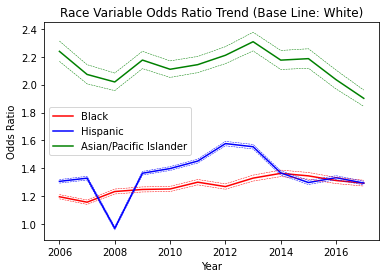

In [28]:
# plot
import seaborn as sns
years = list(range(2006, 2018))
sns.lineplot(x = years, y = black, color = 'red', label="Black")
sns.lineplot(x = years, y = hispanic, color = 'blue', label="Hispanic")
sns.lineplot(x = years, y = asianpacific, color = 'green', label="Asian/Pacific Islander")

sns.lineplot(x = years, y = black_low, color = 'red', linestyle='--',linewidth =0.5)
sns.lineplot(x = years, y = hispanic_low, color = 'blue', linestyle='--',linewidth =0.5)
sns.lineplot(x = years, y = asianpacific_low, color = 'green', linestyle='--',linewidth =0.5)

sns.lineplot(x = years, y = black_high, color = 'red', linestyle='--',linewidth =0.5)
sns.lineplot(x = years, y = hispanic_high, color = 'blue', linestyle='--',linewidth =0.5)
sns.lineplot(x = years, y = asianpacific_high, color = 'green', linestyle='--',linewidth =0.5)

plt.title('Race Variable Odds Ratio Trend (Base Line: White)')
plt.xlabel('Year')
plt.ylabel('Odds Ratio')
plt.legend()
#plt.savefig('Race_Odds_Ratio_Trend(Single Speeding).svg', format = 'svg')
plt.savefig('Race_Odds_Ratio_Trend(Single Speeding).jpg', dpi=200)
plt.show()

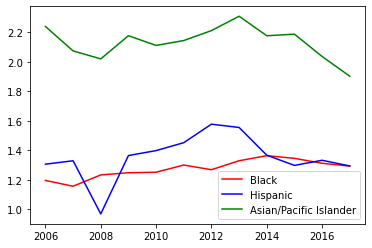

In [29]:
years = list(range(2006, 2018))
sns.lineplot(x = years, y = black, color = 'red', label="Black")
sns.lineplot(x = years, y = hispanic, color = 'blue', label="Hispanic")
sns.lineplot(x = years, y = asianpacific, color = 'green', label="Asian/Pacific Islander")

In [30]:
# first create folder and write to csv files
file_name = 'baseline_speedingonly_yearwise.csv'
save_path = '/gdrive/MyDrive/traffic_stop/output_0205/' + file_name
res_df.to_csv(save_path)

### school zone logistic regression (all year combined, the only violation is 'speeding-school zone')

In [31]:
#var_lst_interaction = ['subject_race_black', 'subject_race_hispanic', 'subject_race_asian/pacific islander',
                    #'holiday', 'county_type_Non core', 'county_type_Micropolitan',
                    #'hispanic_metro','black_metro','asian/paci_metro']

var_lst_baseline = ['subject_race_black', 'subject_race_hispanic', 'subject_race_asian/pacific islander',
                    'holiday', 'county_type_Non core', 'county_type_Micropolitan']

# num_feat = len(df_16.columns)

# this df is later pass into run_year_analysis to get all estimates
#df_years = pd.DataFrame({'variable':var_lst_interaction})
df_years = pd.DataFrame({'variable':var_lst_baseline})

# keep track of coefficient estimates and evaluation metrics
asianpacific = []	
black = []	
hispanic = []	

asianpacific_low = []	
black_low = []	
hispanic_low = []

asianpacific_high = []	
black_high = []	
hispanic_high = []

In [32]:
data_path = '/gdrive/MyDrive/traffic_stop/year_data_speeding_only/'
res_df = run_year_analysis(data_path, output_path = ' ', df_years = df_years, school = True, model = 'baseline')

***********************************
school zone
Metropolitan    11702
Micropolitan    4691 
Non core        3096 
Name: county_type, dtype: int64
# of school zone speeding: 19489
1    10421
0    9068 
Name: citation_issued, dtype: int64
Index(['holiday', 'subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_race_white',
       'county_type_Metropolitan', 'county_type_Micropolitan',
       'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.672509
         Iterations 5


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [33]:
res_df

,variable,coef,odds_ratio,lower_CI,upper_CI,pvalue
0,const,0.266369,1.305216,1.247002,1.366148,2.568021e-30
1,holiday,-0.984420,0.373656,0.321415,0.434388,1.416999e-37
2,subject_race_asian/pacific islander,0.380687,1.463289,1.196320,1.789835,2.121764e-04
3,subject_race_black,0.278037,1.320536,1.186807,1.469333,3.328097e-07
4,subject_race_hispanic,0.346686,1.414373,1.328002,1.506360,4.103835e-27
5,county_type_Micropolitan,-0.648513,0.522823,0.487585,0.560607,3.851039e-74
6,county_type_Non core,-0.512530,0.598978,0.552483,0.649387,1.753535e-35


In [36]:
res_df.round(4)

,variable,coef,odds_ratio,lower_CI,upper_CI,pvalue
0,const,0.2664,1.3052,1.2470,1.3661,0.0000
1,holiday,-0.9844,0.3737,0.3214,0.4344,0.0000
2,subject_race_asian/pacific islander,0.3807,1.4633,1.1963,1.7898,0.0002
3,subject_race_black,0.2780,1.3205,1.1868,1.4693,0.0000
4,subject_race_hispanic,0.3467,1.4144,1.3280,1.5064,0.0000
5,county_type_Micropolitan,-0.6485,0.5228,0.4876,0.5606,0.0000
6,county_type_Non core,-0.5125,0.5990,0.5525,0.6494,0.0000


In [37]:
# first create folder and write to csv files
file_name = 'baseline_schoolzone.csv'
save_path = '/gdrive/MyDrive/traffic_stop/output_0205/' + file_name
res_df.to_csv(save_path)

### Race distribution **of citation** in speeding over limit (% of drivers getting citation)

In [38]:
def race_distribution(speeding_type):
  df_cite = pd.Series([0]*4, index = ['white','hispanic','black','asian/pacific islander'])
  df_all = pd.Series([0]*4, index = ['white','hispanic','black','asian/pacific islander'])
  years = list(range(2006, 2018))

  for year in years:
    file_name = '/gdrive/MyDrive/traffic_stop/year_data_speeding_only/traffic_' + str(year) + '.parquet'
    df = pd.read_parquet(file_name, engine = 'pyarrow')

    # drop unrelated columns
    #df.drop(col_drop, axis = 1, inplace = True)
    #df = df[keep_col]

    print('*****************************************************')
    print(year)

    # consider only one speeding violation
    df = df.loc[df['speeding_only'].isin(['speeding-repeated_entries','speeding-1'])]

    for race in ['white','hispanic','black','asian/pacific islander']:
      df_all[race] += len(df.loc[(df['subject_race'] == race) & (df['violation'] == speeding_type),:])
      if speeding_type == 'speeding over limit':
        df_cite[race] += len(df.loc[(df['citation_issued'] == 1) & (df['subject_race'] == race) & (df['violation'] == speeding_type),:])
      else:
        df_cite[race] += len(df.loc[(df['citation_issued'] == 0) & (df['subject_race'] == race) & (df['violation'] == speeding_type),:])
  print(speeding_type)
  print('df_all: ')
  print(df_all)
  print('df_cite: ')
  print(df_cite)
  cite_pct = df_cite.divide(df_all)
  cite_pct.sort_index(inplace = True)
  print(cite_pct)
  sns.barplot(x=list(cite_pct.index), y=cite_pct)
  if speeding_type in ['unsafe speed','fail to control speed','speeding-10% or more above posted speed']:
    plt.ylabel('% of drivers not getting citation')
  else:
    plt.ylabel('% of drivers getting citation')
  plt.title(('Race distribution in ' + speeding_type))
  plt.savefig(('%citation_' + speeding_type + '.svg'), format = 'svg')
  plt.savefig(('%citation_' + speeding_type + '.jpg'), dpi = 200)
  plt.show()

*****************************************************
2006
*****************************************************
2007
*****************************************************
2008
*****************************************************
2009
*****************************************************
2010
*****************************************************
2011
*****************************************************
2012
*****************************************************
2013
*****************************************************
2014
*****************************************************
2015
*****************************************************
2016
*****************************************************
2017
unsafe speed
df_all: 
white                     52879
hispanic                  17764
black                     7346 
asian/pacific islander    1511 
dtype: int64
df_cite: 
white                     801
hispanic                  613
black                     120
asian/pacific islander    28 

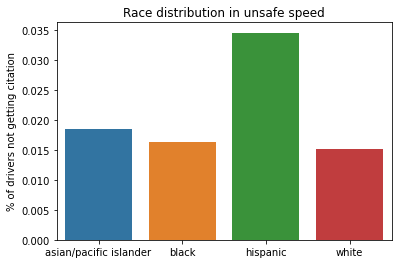

*****************************************************
2006
*****************************************************
2007
*****************************************************
2008
*****************************************************
2009
*****************************************************
2010
*****************************************************
2011
*****************************************************
2012
*****************************************************
2013
*****************************************************
2014
*****************************************************
2015
*****************************************************
2016
*****************************************************
2017
fail to control speed
df_all: 
white                     61134
hispanic                  17953
black                     7749 
asian/pacific islander    1828 
dtype: int64
df_cite: 
white                     842
hispanic                  421
black                     172
asian/pacific island

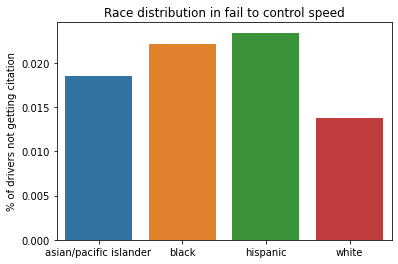

*****************************************************
2006
*****************************************************
2007
*****************************************************
2008
*****************************************************
2009
*****************************************************
2010
*****************************************************
2011
*****************************************************
2012
*****************************************************
2013
*****************************************************
2014
*****************************************************
2015
*****************************************************
2016
*****************************************************
2017
speeding-10% or more above posted speed
df_all: 
white                     2109068
hispanic                  964141 
black                     342859 
asian/pacific islander    94856  
dtype: int64
df_cite: 
white                     48904
hispanic                  26216
black               

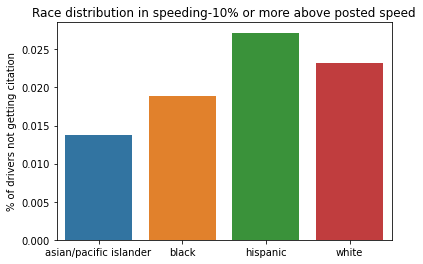

*****************************************************
2006
*****************************************************
2007
*****************************************************
2008
*****************************************************
2009
*****************************************************
2010
*****************************************************
2011
*****************************************************
2012
*****************************************************
2013
*****************************************************
2014
*****************************************************
2015
*****************************************************
2016
*****************************************************
2017
speeding over limit
df_all: 
white                     5418665
hispanic                  1887721
black                     694991 
asian/pacific islander    116290 
dtype: int64
df_cite: 
white                     13085
hispanic                  6279 
black                     1552 
asian/pa

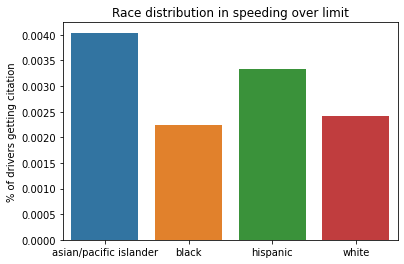

In [39]:
low_vio_lst = ['unsafe speed','fail to control speed','speeding-10% or more above posted speed','speeding over limit']
for vio in low_vio_lst:
  race_distribution(vio)

### Race distribution in speeding over limit (# driver has a single violation and it is 'speeding over limit'/ # driver has single speeding violation)

*****************************************************
2006
Only speeding related records:  1234128
Types: 
speeding-1                   1233843
speeding-multiple            234    
speeding-repeated_entries    51     
Name: speeding_only, dtype: int64
Single speeding records:  1233894
*****************************************************
2007
Only speeding related records:  1110125
Types: 
speeding-1                   1109832
speeding-multiple            260    
speeding-repeated_entries    33     
Name: speeding_only, dtype: int64
Single speeding records:  1109865
*****************************************************
2008
Only speeding related records:  1113530
Types: 
speeding-1                   1113110
speeding-multiple            383    
speeding-repeated_entries    37     
Name: speeding_only, dtype: int64
Single speeding records:  1113147
*****************************************************
2009
Only speeding related records:  1092598
Types: 
speeding-1                   109180

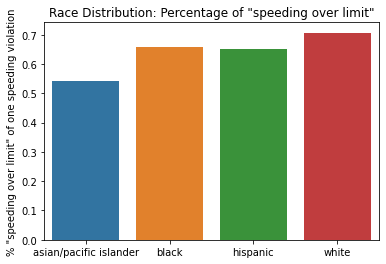

In [40]:
df_limit = pd.Series([0]*4, index = ['white','hispanic','black','asian/pacific islander'])
df_all = pd.Series([0]*4, index = ['white','hispanic','black','asian/pacific islander'])

years = list(range(2006,2018))

for year in years:

  file_name = '/gdrive/MyDrive/traffic_stop/year_data_speeding_only/traffic_' + str(year) + '.parquet'
  df = pd.read_parquet(file_name, engine = 'pyarrow')

  print('*****************************************************')
  print(year)
  print('Only speeding related records: ', len(df))
  print('Types: ')
  print(df['speeding_only'].value_counts())

  # consider only single speeding violation
  df = df.loc[df['speeding_only'].isin(['speeding-repeated_entries','speeding-1'])]

  print('Single speeding records: ', len(df))

  # filter out search_conducted = True
  for race in ['white','hispanic','black','asian/pacific islander']:
    df_all[race] += len(df.loc[df['subject_race'] == race,:])
    df_limit[race] += len(df.loc[((df['violation'] == 'speeding over limit') & (df['subject_race'] == race)),:])

print('df_all: ')
print(df_all)
print('df_limit: ')
print(df_limit)
limit_pct = df_limit.divide(df_all)
limit_pct.sort_index(inplace = True)
print(limit_pct)
sns.barplot(x=list(limit_pct.index), y=limit_pct)
plt.ylabel('% "speeding over limit" of one speeding violation')
plt.title('Race Distribution: Percentage of "speeding over limit"')
plt.savefig('%speedingoverlimit.svg', format = 'svg')
plt.savefig('%speedingoverlimit.jpg', dpi = 200)
plt.show()

### Race distribution of **search_conducted** in speeding only (# drivers searched/ # drivers have only speeding violation)

*****************************************************
2006
Only speeding (No other violations) records:  1234128
Types: 
speeding-1                   1233843
speeding-multiple            234    
speeding-repeated_entries    51     
Name: speeding_only, dtype: int64
*****************************************************
2007
Only speeding (No other violations) records:  1110125
Types: 
speeding-1                   1109832
speeding-multiple            260    
speeding-repeated_entries    33     
Name: speeding_only, dtype: int64
*****************************************************
2008
Only speeding (No other violations) records:  1113530
Types: 
speeding-1                   1113110
speeding-multiple            383    
speeding-repeated_entries    37     
Name: speeding_only, dtype: int64
*****************************************************
2009
Only speeding (No other violations) records:  1092598
Types: 
speeding-1                   1091803
speeding-multiple            771    
speedin

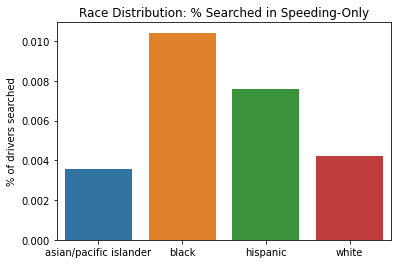

In [41]:
df_search = pd.Series([0]*4, index = ['white','hispanic','black','asian/pacific islander'])
df_all = pd.Series([0]*4, index = ['white','hispanic','black','asian/pacific islander'])

years = list(range(2006, 2018))

for year in years:
  file_name = '/gdrive/MyDrive/traffic_stop/year_data_speeding_only/traffic_' + str(year) + '.parquet'
  df = pd.read_parquet(file_name, engine = 'pyarrow')

  print('*****************************************************')
  print(year)
  print('Only speeding (No other violations) records: ', len(df))
  print('Types: ')
  print(df['speeding_only'].value_counts())

  # filter out rows with violations other than speeding
  # not selecting equal to df = df.loc[df['speeding_only'].isin(['speeding-repeated_entries','speeding-1', 'speeding-multiple'])]

  # filter out search_conducted = True
  for race in ['white','hispanic','black','asian/pacific islander']:
    df_all[race] += len(df.loc[df['subject_race'] == race,:])
    df_search[race] += len(df.loc[((df['search_conducted'] == 1) & (df['subject_race'] == race)),:])

print('df_all: ')
print(df_all)
print('df_search: ')
print(df_search)
search_pct = df_search.divide(df_all)
search_pct.sort_index(inplace = True)
print(search_pct)
sns.barplot(x=list(search_pct.index), y=search_pct)

plt.ylabel('% of drivers searched')
plt.title('Race Distribution: % Searched in Speeding-Only')
plt.savefig('%searched_speedingonly.svg', format = 'svg')
plt.savefig('%searched_speedingonly.jpg', dpi = 200)
plt.show()


### Race distribution of **search_conducted** in low-citation-rate speeding only (# drivers searched/ # drivers have only speeding violation)


*****************************************************
2006
Only speeding (No other violations) records:  1234128
Types: 
speeding-1                   1233843
speeding-multiple            234    
speeding-repeated_entries    51     
Name: speeding_only, dtype: int64
*****************************************************
2007
Only speeding (No other violations) records:  1110125
Types: 
speeding-1                   1109832
speeding-multiple            260    
speeding-repeated_entries    33     
Name: speeding_only, dtype: int64
*****************************************************
2008
Only speeding (No other violations) records:  1113530
Types: 
speeding-1                   1113110
speeding-multiple            383    
speeding-repeated_entries    37     
Name: speeding_only, dtype: int64
*****************************************************
2009
Only speeding (No other violations) records:  1092598
Types: 
speeding-1                   1091803
speeding-multiple            771    
speedin

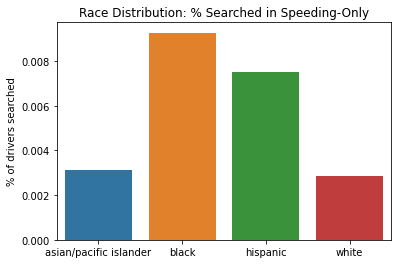

In [43]:
df_search = pd.Series([0]*4, index = ['white','hispanic','black','asian/pacific islander'])
df_all = pd.Series([0]*4, index = ['white','hispanic','black','asian/pacific islander'])

years = list(range(2006, 2018))

for year in years:
  file_name = '/gdrive/MyDrive/traffic_stop/year_data_speeding_only/traffic_' + str(year) + '.parquet'
  df = pd.read_parquet(file_name, engine = 'pyarrow')

  print('*****************************************************')
  print(year)
  print('Only speeding (No other violations) records: ', len(df))
  print('Types: ')
  print(df['speeding_only'].value_counts())

  # we want low-citation rate, do not include multiple violations
  df = df.loc[df['speeding_only'].isin(['speeding-repeated_entries','speeding-1'])]
  df = df.loc[~df['violation'].isin(['speeding-10% or more above posted speed','unsafe speed',
                                     'fail to control speed','speeding cmv 15 mph or more over limit']),:]

  # filter out search_conducted = True
  for race in ['white','hispanic','black','asian/pacific islander']:
    df_all[race] += len(df.loc[df['subject_race'] == race,:])
    df_search[race] += len(df.loc[((df['search_conducted'] == 1) & (df['subject_race'] == race)),:])

print('df_all: ')
print(df_all)
print('df_search: ')
print(df_search)
search_pct = df_search.divide(df_all)
search_pct.sort_index(inplace = True)
print(search_pct)
sns.barplot(x=list(search_pct.index), y=search_pct)

plt.ylabel('% of drivers searched')
plt.title('Race Distribution: % Searched in Speeding-Only')
plt.savefig('%searched_lowrate_speedingonly.svg', format = 'svg')
plt.savefig('%searched_lowrate_speedingonly.jpg', dpi = 200)
plt.show()


### Ratio of contraband found divided by vehicle searched for individual races

search_conducted vs vehicle_searched

search_conducted vs contraband_found

contraband_found vs vehicle_searched

for each race, contraband_found/search_conducted

In [58]:
data = pd.read_parquet('/gdrive/MyDrive/traffic_stop/year_data/traffic_' +str(2013) + '.parquet', engine = 'pyarrow')

In [59]:
data['search_vehicle'].value_counts(dropna=False)

False    2110178
NaN      24758  
Name: search_vehicle, dtype: int64

In [49]:
# for all search_conducted = True, search_vehicle = False
print(data.loc[data['search_conducted'] == 1,:]['search_vehicle'].value_counts(dropna = False))
# search_vehicle is never 1
print(data.loc[data['search_vehicle'] == 1,:]['search_conducted'].value_counts(dropna = False))

False    30571
NaN      18   
Name: search_vehicle, dtype: int64
Series([], Name: search_conducted, dtype: int64)


In [64]:
print(data.loc[data['search_vehicle'] == 1,:]['contraband_found'].value_counts())
print(data.loc[data['contraband_found'] == 1,:]['search_vehicle'].value_counts())

Series([], Name: contraband_found, dtype: int64)
False    4305
Name: search_vehicle, dtype: int64


In [62]:
print(data.loc[data['search_conducted'] == 1,:]['contraband_found'].value_counts(dropna = False))
print(data.loc[data['contraband_found'] == 1,:]['search_conducted'].value_counts(dropna = False))

False    22613
True     13937
Name: contraband_found, dtype: int64
True    13937
Name: search_conducted, dtype: int64


*****************************************************
2006
Only speeding (No other violations) records:  1234128
Types: 
speeding-1                   1233843
speeding-multiple            234    
speeding-repeated_entries    51     
Name: speeding_only, dtype: int64
*****************************************************
2007
Only speeding (No other violations) records:  1110125
Types: 
speeding-1                   1109832
speeding-multiple            260    
speeding-repeated_entries    33     
Name: speeding_only, dtype: int64
*****************************************************
2008
Only speeding (No other violations) records:  1113530
Types: 
speeding-1                   1113110
speeding-multiple            383    
speeding-repeated_entries    37     
Name: speeding_only, dtype: int64
*****************************************************
2009
Only speeding (No other violations) records:  1092598
Types: 
speeding-1                   1091803
speeding-multiple            771    
speedin

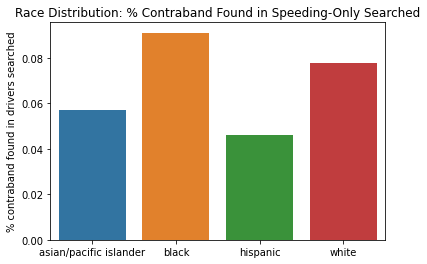

In [65]:
df_search = pd.Series([0]*4, index = ['white','hispanic','black','asian/pacific islander'])
df_found = pd.Series([0]*4, index = ['white','hispanic','black','asian/pacific islander'])

years = list(range(2006, 2018))

for year in years:
  file_name = '/gdrive/MyDrive/traffic_stop/year_data_speeding_only/traffic_' + str(year) + '.parquet'
  df = pd.read_parquet(file_name, engine = 'pyarrow')

  print('*****************************************************')
  print(year)
  print('Only speeding (No other violations) records: ', len(df))
  print('Types: ')
  print(df['speeding_only'].value_counts())

  # filter out search_conducted = True
  for race in ['white','hispanic','black','asian/pacific islander']:
    df_search[race] += len(df.loc[((df['search_conducted'] == 1) & (df['subject_race'] == race)),:])
    df_found[race] += len(df.loc[((df['search_conducted'] == 1) & (df['subject_race'] == race) & (df['contraband_found'] == 1)),:])

print('df_searched: ')
print(df_search)
print('df_found: ')
print(df_found)
found_pct = df_found.divide(df_search)
found_pct.sort_index(inplace = True)
print(found_pct)
sns.barplot(x=list(found_pct.index), y=found_pct)

plt.ylabel('% contraband found in drivers searched')
plt.title('Race Distribution: % Contraband Found in Speeding-Only Searched')
plt.savefig('%contraband_searched.svg', format = 'svg')
plt.savefig('%contraband_searched.jpg', dpi = 200)
plt.show()
